## This notebook generates the figures and data on non-identically distributed noise models. 


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import os 
from collections import defaultdict

## Import the data

In [18]:
def import_data():
    def empty_dict():
        return(defaultdict(empty_dict))
    data = defaultdict(empty_dict)
    
    for file in os.listdir("./data/"):
        if os.path.isfile("./data/" +file) == True:
            with open("./data/" +file) as f:
                new_data = json.load(f)
                data[new_data['code_name']][new_data['decoding_method']][new_data['std_t_err']][new_data['std_p_err']] = new_data['data']
    return(data)

data = import_data()

## Functions for calculating thresholds and plotting

In [19]:
def threshold_fit(variables, B0, B1, B2, mu, pth):
    p, L = variables
    return(B0 + B1*(p-pth)*pow(L, 1/mu) + B2*pow((p-pth) * pow(L, 1/mu), 2))


def plot_per_vs_ler(per_array, ler_per_distances, ler_eb_per_distances, labels):
    for index,ler_per_distance in enumerate(ler_per_distances):
        for distance in ler_per_distance:
            plt.errorbar(per_array, ler_per_distance[distance], yerr=ler_eb_per_distances[index]
                         [distance], label='d = ' + str(distance) + str(labels[index]))
    plt.legend()
    plt.yscale("log")
    plt.xlabel("physical error rate")
    plt.ylabel("logical error rate")

def plot_ler_vs_distance(code_dict, per, code_label,marker_style,line_style,colour,ax):
    distances = []
    ler = []
    ler_eb = []
    n_qubits = []
    for distance in code_dict:
        if int(distance) in [5, 7, 9, 13, 17, 21]:
            distances.append(int(distance))


    distances.sort()
    for distance in distances:
        if str(per) in code_dict[str(distance)].keys(): 
            if code_dict[str(distance)][str(per)]['total_run_count_all_models'] > 50:
                ler.append(code_dict[str(distance)][str(per)]['ler']/code_dict[str(distance)][str(per)]['total_run_count_all_models'])
                ler_eb.append(np.sqrt(
                    (1-ler[-1])*ler[-1]/code_dict[str(distance)][str(per)]['run_count']))
                n_qubits.append(np.sqrt(code_dict[str(distance)]["N"]))
    ax.errorbar(n_qubits, ler, label=code_label, yerr=ler_eb,marker=marker_style,linestyle=line_style,color=colour, linewidth=4,markersize=18)

    ax.set_yscale('log')
    ax.legend(loc='lower left', prop={'size': 24})
    ax.set_ylabel('Logical failure rate', size=28)
    ax.set_xlabel('Code distance $\it{d}$', size=28)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', direction='out', length=18, width=2, colors='black', grid_color='black', grid_alpha=1)
    ax.tick_params(axis='both', which='minor', direction='out', length=9, width=2, colors='black', grid_color='black', grid_alpha=1)

def get_ler(data_dict,min_per, max_per,non_uniform):

    ler_eb = []
    ler_array = []
    per_array = []
    for per in data_dict:
        if per != 'N':
            if float(per)>min_per and float(per)< max_per:
                per_array.append(float(per))
    per_array.sort()
    for per in per_array:
        ler_array.append(data_dict[str(
            per)]['ler']/data_dict[str(per)]['total_run_count_all_models'])
        ler_eb.append(3*data_dict[str(per)]['ler_eb'])

    return(per_array, ler_array, ler_eb)
        
def calculate_threshold(code_dict, min_distance, max_distance,min_per, max_per, title, ax=None, calculate_threshold=True, non_uniform=False):

    ler_data = []
    ler_eb_data = []
    per_data = []
    distance_data = []
    for distance in code_dict:
        if int(distance) > min_distance and int(distance) < max_distance:
            per_array, ler_array, ler_eb = get_ler(code_dict[str(distance)],min_per, max_per, get_ler)
            per_data.extend(per_array)
            ler_data.extend(ler_array)
            ler_eb_data.extend(ler_eb)
            distance_data.extend([int(distance) for _ in range(len(per_array))])

    if calculate_threshold:
        popt, pcov = curve_fit(threshold_fit, (per_data, distance_data),
                                ler_data, sigma=
                                ler_eb_data ,maxfev=5000) 
        if ax !=None:
            ax.axvline(x = popt[-1], color = 'black', linestyle = 'dashed')
        error = np.sqrt(np.diag(pcov))[-1]

    distance_array = []
    for distance in code_dict:
        if int(distance) > min_distance and int(distance) < max_distance:
                    distance_array.append(int(distance))

    distance_array.sort()
    for distance in distance_array:
        per_array, ler_array, ler_eb = get_ler(code_dict[str(distance)],min_per, max_per,non_uniform)

        if per_array != []:
            if ax != None:
                ax.errorbar(per_array,ler_array,yerr=ler_eb,label = 'd = ' + str(distance), fmt = 'o')   

        if calculate_threshold:
            if ax != None:
                ax.plot(per_array, threshold_fit(
                    (per_array, [int(distance) for _ in range(len(per_array))]), *popt), color='grey')

    if ax != None:
        ax.legend()
        ax.set_xlabel('physical error rate')
        ax.set_ylabel('logical error rate')
        ax.set_title(title)

    if calculate_threshold:
        return(popt[-1], error)



## Data for table 1

All 18 thresholds in table 1 of the paper are printed with their error. The first cell calculates the results in the top half of the table and the second cell the second half.

In [20]:
print(calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0][0], 4, 12, 0.155, 0.17,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'CSS manhatten, sigma_tot = 0, sigma_p = 0')

print(calculate_threshold(data['MMHH']['MWPM_manhatten'][0][0], 4, 12, 0.155, 0.17,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MMHH manhatten, sigma_tot = 0, sigma_p = 0')

print(calculate_threshold(data['MHHM']['MWPM_average'][0][0], 4, 12, 0.155, 0.17,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True), 'MHHM manhatten, sigma_tot = 0, sigma_p = 0')

print(calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0][0.5], 5, 22, 0.155, 0.172,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'CSS manhatten, sigma_tot = 0, sigma_p = 0.5')

print(calculate_threshold(data['MMHH']['MWPM_manhatten'][0][0.5], 6, 22, 0.17, 0.19,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True,), 'MMHH manhatten, sigma_tot = 0, sigma_p = 0.5')

print(calculate_threshold(data['MHHM']['MWPM_average'][0][0.5], 4, 22, 0.16, 0.18,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True,), 'MHHM manhatten, sigma_tot = 0, sigma_p = 0.5')

print(calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0], 6, 22, 0.15, 0.18,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True), 'CSS manhatten, sigma_tot = 0.5, sigma_p = 0')

print(calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0], 6, 22, 0.15, 0.18,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True), 'MMHH manhatten, sigma_tot = 0.5, sigma_p = 0')

print(calculate_threshold(data['MHHM']['MWPM_average'][0.5][0], 4, 22, 0.16, 0.18,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True),'MHHM manhatten, sigma_tot = 0.5, sigma_p = 0')

print(calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0.5], 6, 22, 0.16, 0.19,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True), 'CSS manhatten, sigma_tot = 0.5, sigma_p = 0.5')

print(calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0.5], 4, 22, 0.16, 0.19,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True), 'MMHH manhatten, sigma_tot = 0.5, sigma_p = 0.5')

print(calculate_threshold(data['MHHM']['MWPM_average'][0.5][0.5], 4, 22, 0.16, 0.19,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True),'MHHM manhatten, sigma_tot = 0.5, sigma_p = 0.5')

plt.show()

(0.16242854578894914, 0.0003924693527907809) CSS manhatten, sigma_tot = 0, sigma_p = 0
(0.16382968838959489, 0.0006608279644696114) MMHH manhatten, sigma_tot = 0, sigma_p = 0
(0.16353863570972985, 0.0005529826551626855) MHHM manhatten, sigma_tot = 0, sigma_p = 0
(0.162590057903525, 0.0002089032234492716) CSS manhatten, sigma_tot = 0, sigma_p = 0.5
(0.1843542631811745, 0.00016329845744043805) MMHH manhatten, sigma_tot = 0, sigma_p = 0.5
(0.18566994252524738, 0.0039345511689712065) MHHM manhatten, sigma_tot = 0, sigma_p = 0.5
(0.16607914497320417, 0.0004209776260831515) CSS manhatten, sigma_tot = 0.5, sigma_p = 0
(0.1648158929954055, 0.0003173164535701796) MMHH manhatten, sigma_tot = 0.5, sigma_p = 0
(0.16390436692596794, 0.0004231541836235345) MHHM manhatten, sigma_tot = 0.5, sigma_p = 0
(0.16388394694611147, 0.0004337268158729908) CSS manhatten, sigma_tot = 0.5, sigma_p = 0.5
(0.18564738842219755, 0.00041132520751529367) MMHH manhatten, sigma_tot = 0.5, sigma_p = 0.5
(0.188750061382165

In [21]:
print(calculate_threshold(data['Surface_Code']['MWPM'][0][0], 4, 22, 0.155, 0.17,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'CSS manhatten, sigma_tot = 0, sigma_p = 0')

print(calculate_threshold(data['MMHH']['MWPM'][0][0], 4, 22, 0.155, 0.17,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MMHH manhatten, sigma_tot = 0, sigma_p = 0')

print(calculate_threshold(data['MHHM']['MWPM'][0][0], 4, 22, 0.155, 0.17,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MHHM, sigma_tot = 0, sigma_p = 0')

print(calculate_threshold(data['Surface_Code']['MWPM'][0][0.5], 5, 22, 0.155, 0.172,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'CSS, sigma_tot = 0, sigma_p = 0.5')

print(calculate_threshold(data['MMHH']['MWPM'][0][0.5], 6, 22, 0.18, 0.2,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MMHH, sigma_tot = 0, sigma_p = 0.5')

print(calculate_threshold(data['MHHM']['MWPM'][0][0.5], 4, 22, 0.18, 0.2,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MHHM, sigma_tot = 0, sigma_p = 0.5')

print(calculate_threshold(data['Surface_Code']['MWPM'][0.5][0], 6, 22, 0.15, 0.18,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'CSS, sigma_tot = 0.5, sigma_p = 0')

print(calculate_threshold(data['MMHH']['MWPM'][0.5][0], 6, 22, 0.15, 0.18,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MMHH, sigma_tot = 0.5, sigma_p = 0')

print(calculate_threshold(data['MHHM']['MWPM'][0.5][0], 4, 22, 0.16, 0.18,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MHHM, sigma_tot = 0.5, sigma_p = 0')

print(calculate_threshold(data['Surface_Code']['MWPM'][0.5][0.5], 6, 22, 0.17, 0.19,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'CSS, sigma_tot = 0.5, sigma_p = 0.5')

print(calculate_threshold(data['MMHH']['MWPM'][0.5][0.5], 4, 22, 0.19, 0.21,
                    'MHHM MWPM average', calculate_threshold=True, non_uniform=True), 'MMHH, sigma_tot = 0.5, sigma_p = 0.5')

print(calculate_threshold(data['MHHM']['MWPM'][0.5][0.5], 4, 22, 0.19, 0.21,
                    'MHHM MWPM average',  calculate_threshold=True, non_uniform=True),'MHHM, sigma_tot = 0.5, sigma_p = 0.5')


(0.1628007356122413, 0.000566854084963805) CSS manhatten, sigma_tot = 0, sigma_p = 0
(0.16224510400600936, 0.0003821292041651245) MMHH manhatten, sigma_tot = 0, sigma_p = 0
(0.1648790224584836, 0.00068645044044355) MHHM, sigma_tot = 0, sigma_p = 0
(0.1679066977518873, 0.00020699452578330175) CSS, sigma_tot = 0, sigma_p = 0.5
(0.18976038825402308, 8.738186543806211e-05) MMHH, sigma_tot = 0, sigma_p = 0.5
(0.1898009946168576, 0.00018939039123836416) MHHM, sigma_tot = 0, sigma_p = 0.5
(0.17829051463223192, 0.0009294982817115249) CSS, sigma_tot = 0.5, sigma_p = 0
(0.17816448783883612, 0.0002800758365612183) MMHH, sigma_tot = 0.5, sigma_p = 0
(0.17798773090145462, 0.0003666440393257502) MHHM, sigma_tot = 0.5, sigma_p = 0
(0.18106801341246512, 0.00022348954520275116) CSS, sigma_tot = 0.5, sigma_p = 0.5
(0.20523509612453586, 0.00037736679405889586) MMHH, sigma_tot = 0.5, sigma_p = 0.5
(0.20624272838925464, 0.00040153176881527387) MHHM, sigma_tot = 0.5, sigma_p = 0.5


## Generate figure 5

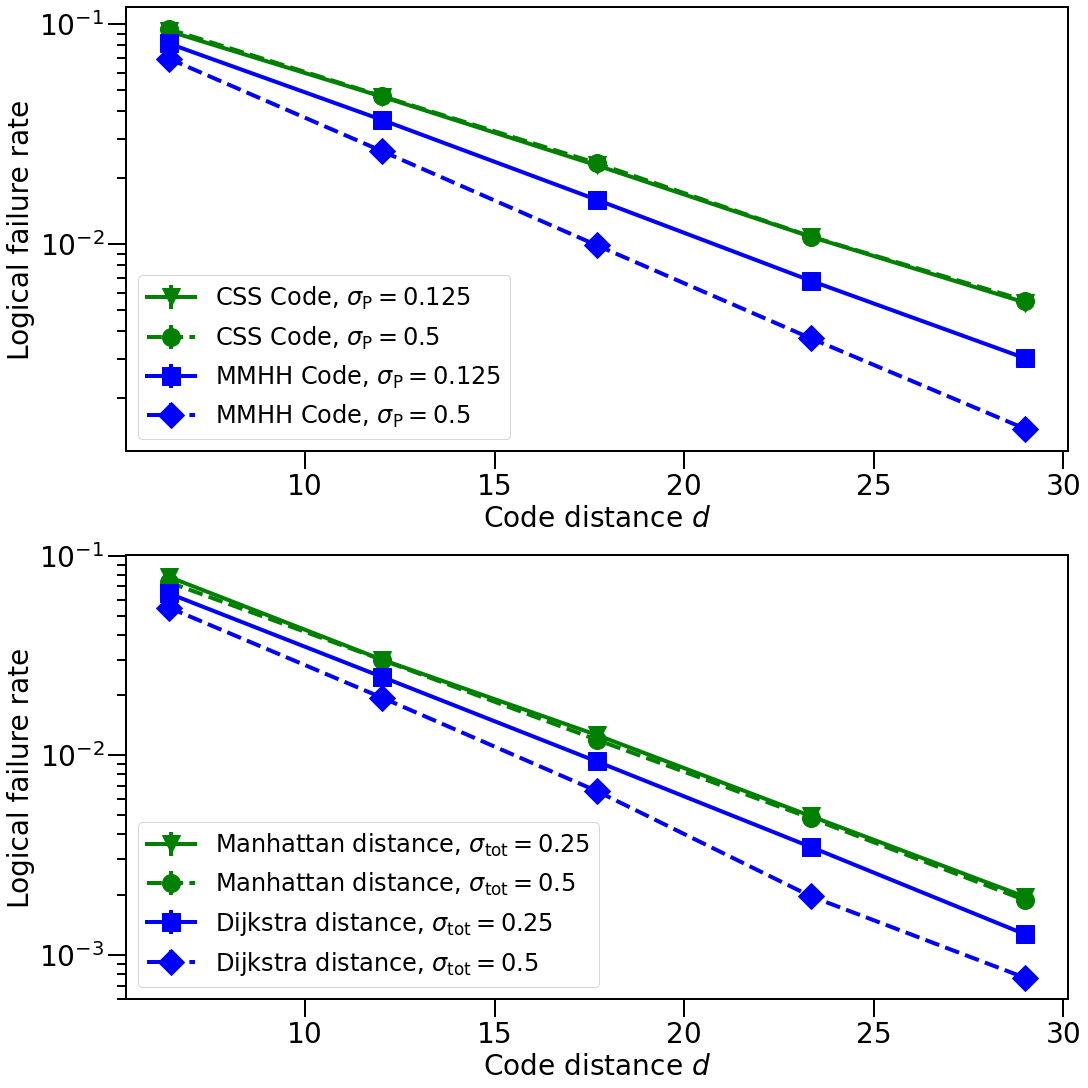

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [22]:
fig, axs = plt.subplot_mosaic([['a)'],['b)']],
                              constrained_layout=True, figsize = (15,15))

plot_ler_vs_distance(data['Surface_Code']['MWPM_manhatten'][0.5][0.125], 0.1, 'CSS Code, $\sigma_{\mathrm{P}}=0.125$', 'v', 'solid', 'green', axs['a)'])
plot_ler_vs_distance(data['Surface_Code']['MWPM_manhatten'][0.5][0.5], 0.1, 'CSS Code, $\sigma_{\mathrm{P}}=0.5$', 'o', 'dashed','green', axs['a)'])
plot_ler_vs_distance(data['MMHH']['MWPM_manhatten'][0.5][0.125], 0.1, 'MMHH Code, $\sigma_{\mathrm{P}}=0.125$', 's', 'solid', 'blue', axs['a)'])
plot_ler_vs_distance(data['MMHH']['MWPM_manhatten'][0.5][0.5], 0.1, 'MMHH Code, $\sigma_{\mathrm{P}}=0.5$', 'D', 'dashed', 'blue', axs['a)'])

plot_ler_vs_distance(data['MMHH']['MWPM_manhatten'][0.25][0.25], 0.1, 'Manhattan distance, $\sigma_{\mathrm{tot}}=0.25$', 'v', 'solid', 'green', axs['b)'])
plot_ler_vs_distance(data['MMHH']['MWPM_manhatten'][0.5][0.25], 0.1, 'Manhattan distance, $\sigma_{\mathrm{tot}}=0.5$', 'o', 'dashed', 'green', axs['b)'])
plot_ler_vs_distance(data['MMHH']['MWPM'][0.25][0.25], 0.1, 'Dijkstra distance, $\sigma_{\mathrm{tot}}=0.25$', 's', 'solid', 'blue', axs['b)'])
plot_ler_vs_distance(data['MMHH']['MWPM'][0.5][0.25], 0.1, 'Dijkstra distance, $\sigma_{\mathrm{tot}}=0.5$', 'D', 'dashed', 'blue', axs['b)'])

axs['a)'].tick_params(axis='both', which='major', labelsize=28)
axs['b)'].tick_params(axis='both', which='major', labelsize=28)

plt.show()
fig.savefig('./5.eps', format='eps', bbox_inches='tight')

## Generate figure 9

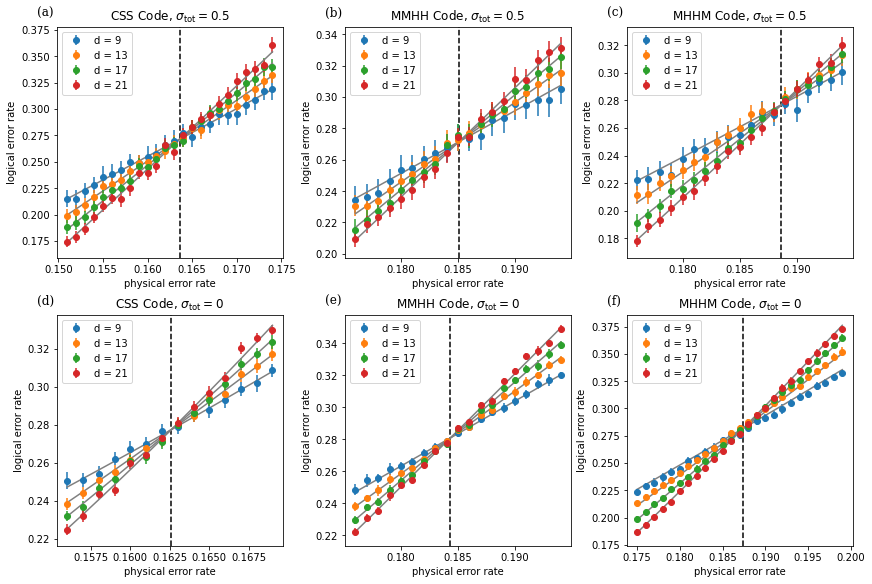

In [23]:
import matplotlib.transforms as mtransforms
fig, axs = plt.subplot_mosaic([['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)']],
                              constrained_layout=True, figsize = (12,8))
thresholds_MMHH_manhatten_05 = dict()
thresholds_Surface_Code_manhatten_05 = dict()
thresholds_MMHH_MWPM = dict()
thresholds_MMHH_manhatten = dict()

thresholds_Surface_Code_manhatten_05[0.5] = calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0.5], 8, 22, 0.15, 0.22, 'CSS Code, $\sigma_{\mathrm{tot}}=0.5$', axs['(a)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_manhatten_05[0.5] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0.5], 8, 22, 0.175, 0.21, 'MMHH Code, $\sigma_{\mathrm{tot}}=0.5$', axs['(b)'], calculate_threshold=True, non_uniform=True)
calculate_threshold(data['MHHM']['MWPM_average'][0.5][0.5], 8, 22, 0.175, 0.21, 'MHHM Code, $\sigma_{\mathrm{tot}}=0.5$', axs['(c)'], calculate_threshold=True, non_uniform=True)
calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0][0.5], 5, 25, 0.155, 0.17, 'CSS Code, $\sigma_{\mathrm{tot}}=0$', axs['(d)'])
thresholds_MMHH_manhatten[0] =calculate_threshold(data['MMHH']['MWPM_manhatten'][0][0.5], 5, 25, 0.175, 0.195, 'MMHH Code, $\sigma_{\mathrm{tot}}=0$', axs['(e)'])
calculate_threshold(data['MHHM']['MWPM_average'][0][0.5], 5, 25, 0.16, 0.2, 'MHHM Code, $\sigma_{\mathrm{tot}}=0$', axs['(f)'], calculate_threshold=True)

thresholds_MMHH_manhatten[0.5] =thresholds_MMHH_manhatten_05[0.5]

for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

plt.show()



## Generate Figure 11

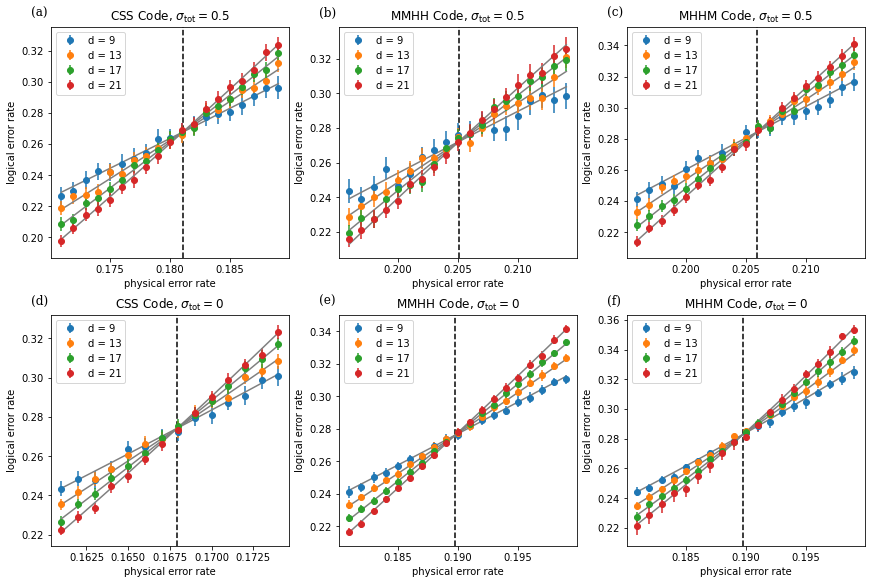

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [24]:
fig, axs = plt.subplot_mosaic([['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)']], constrained_layout=True, figsize=(12, 8))

calculate_threshold(data['Surface_Code']['MWPM'][0.5][0.5], 8, 22, 0.17, 0.19, 'CSS Code, $\sigma_{\mathrm{tot}}=0.5$', axs['(a)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_MWPM[0.5] = calculate_threshold(data['MMHH']['MWPM'][0.5][0.5], 8, 22, 0.195, 0.215, 'MMHH Code, $\sigma_{\mathrm{tot}}=0.5$', axs['(b)'], calculate_threshold=True, non_uniform=True)
calculate_threshold(data['MHHM']['MWPM'][0.5][0.5], 8, 22, 0.195, 0.215, 'MHHM Code, $\sigma_{\mathrm{tot}}=0.5$', axs['(c)'], calculate_threshold=True, non_uniform=True)
calculate_threshold(data['Surface_Code']['MWPM'][0][0.5], 5, 25, 0.16, 0.175, 'CSS Code, $\sigma_{\mathrm{tot}}=0$', axs['(d)'])
calculate_threshold(data['MMHH']['MWPM'][0][0.5], 5, 25, 0.18, 0.2, 'MMHH Code, $\sigma_{\mathrm{tot}}=0$', axs['(e)'])
thresholds_MMHH_MWPM[0] = calculate_threshold(data['MHHM']['MWPM'][0][0.5], 5, 25, 0.18, 0.2, 'MHHM Code, $\sigma_{\mathrm{tot}}=0$', axs['(f)'])
for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

plt.show()
fig.savefig('./Fig_11.eps', format='eps', bbox_inches='tight')


## Generate figure 10

First we need to calculate some thresholds we haven't calculated for previous figures.

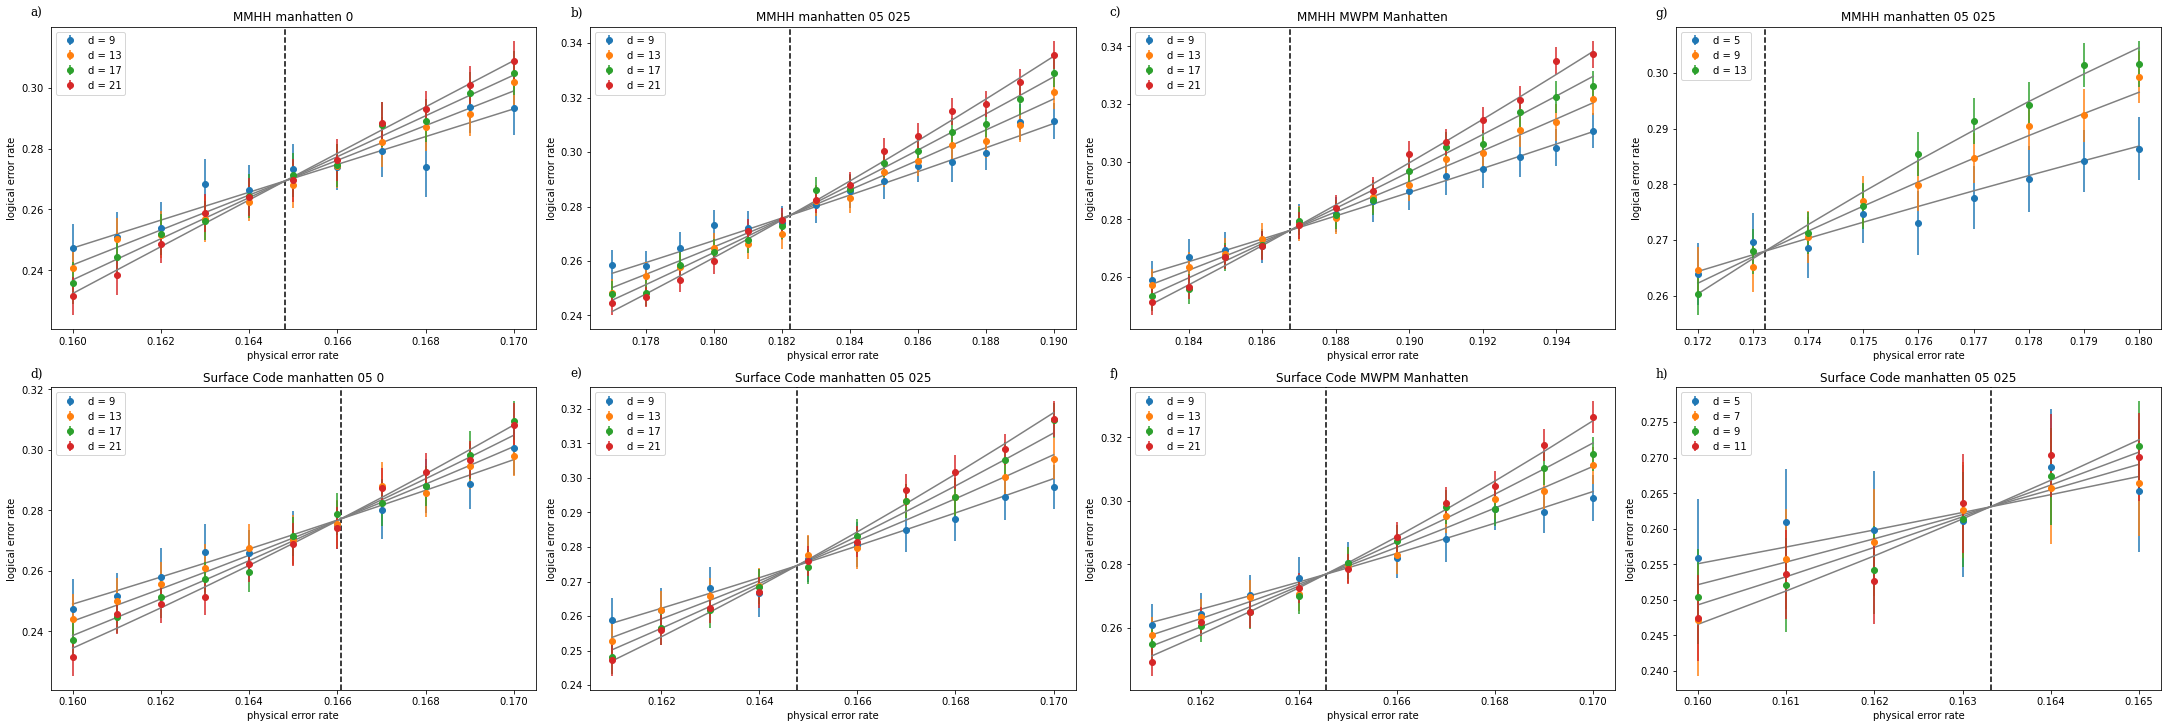

In [25]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)','g)'],['d)','e)', 'f)','h)']],
                              constrained_layout=True, figsize = (30,10))

thresholds_MMHH_manhatten_05[0] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0], 8, 22, 0.14, 0.172,
                    'MMHH manhatten 0', axs['a)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_manhatten_05[0.125] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0.125], 4, 22, 0.15, 0.23,
                    'MMHH manhatten 05 025', axs['g)'], calculate_threshold=True, non_uniform=False)

thresholds_MMHH_manhatten_05[0.25] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0.25], 8, 22, 0.16, 0.23,
                    'MMHH manhatten 05 025', axs['b)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_manhatten_05[0.75] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.5][0.75], 8, 22, 0.16, 0.21,
                    'MMHH MWPM Manhatten', axs['c)'], calculate_threshold=True, non_uniform=True)

thresholds_Surface_Code_manhatten_05[0] = calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0], 8, 22, 0.14, 0.23,
                    'Surface Code manhatten 05 0', axs['d)'], calculate_threshold=True, non_uniform=True)
thresholds_Surface_Code_manhatten_05[0.125] = calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0.125], 4, 22, 0.15, 0.23,
                    'Surface Code manhatten 05 025', axs['h)'], calculate_threshold=True, non_uniform=True)
thresholds_Surface_Code_manhatten_05[0.25] = calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0.25], 4, 22, 0.16, 0.23,
                    'Surface Code manhatten 05 025', axs['e)'], calculate_threshold=True, non_uniform=True)
thresholds_Surface_Code_manhatten_05[0.75] = calculate_threshold(data['Surface_Code']['MWPM_manhatten'][0.5][0.75], 8, 22, 0.16, 0.21,
                    'Surface Code MWPM Manhatten', axs['f)'], calculate_threshold=True, non_uniform=True)




for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')


plt.show()

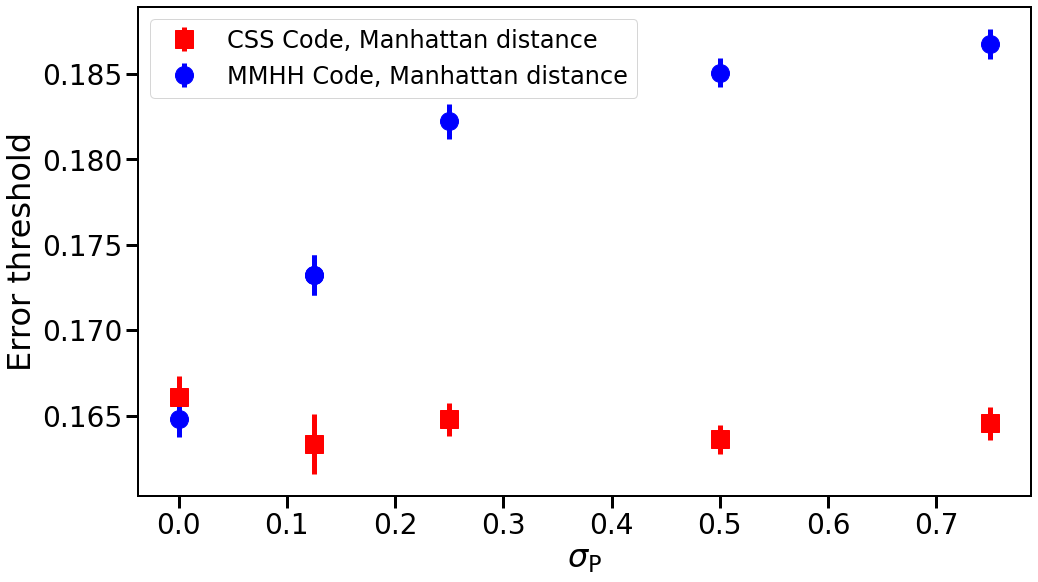

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [26]:
bias_arr = []

for bias in thresholds_Surface_Code_manhatten_05.keys():
    bias_arr.append(bias)
bias_arr.sort()
ler_MMHH_arr = []
ler_Surface_Code_arr = []
ler_MMHH_arr_eb = []
ler_Surface_Code_arr_eb = []
for bias in bias_arr:
    ler_Surface_Code_arr.append(thresholds_Surface_Code_manhatten_05[bias][0])
    ler_Surface_Code_arr_eb.append(3 * thresholds_Surface_Code_manhatten_05[bias][1])


bias_arr_MMHH = []
for bias in thresholds_Surface_Code_manhatten_05.keys():
    bias_arr_MMHH.append(bias)
bias_arr_MMHH.append(0.125)
bias_arr_MMHH.sort()
for bias in bias_arr_MMHH:
    ler_MMHH_arr.append(thresholds_MMHH_manhatten_05[bias][0])
    ler_MMHH_arr_eb.append(3 * thresholds_MMHH_manhatten_05[bias][1])



fig_10, ax_10 = plt.subplots(figsize=(16, 9))
ax_10.errorbar(bias_arr, ler_Surface_Code_arr, yerr=ler_Surface_Code_arr_eb, label='CSS Code, Manhattan distance', marker='s', color='Red', linestyle='', markersize=18, elinewidth=5)
ax_10.errorbar(bias_arr_MMHH, ler_MMHH_arr, yerr=ler_MMHH_arr_eb, label='MMHH Code, Manhattan distance', marker='o', color='Blue', linestyle='', markersize=18, elinewidth=5)
ax_10.spines['left'].set_linewidth(2)
ax_10.spines['right'].set_linewidth(2)
ax_10.spines['top'].set_linewidth(2)
ax_10.spines['bottom'].set_linewidth(2)
ax_10.legend(loc='upper left', prop={'size': 24})
ax_10.set_ylabel('Error threshold', size=32)
ax_10.set_xlabel('$\sigma_{\mathrm{P}}$', size=32)
ax_10.tick_params(axis='both', which='major', direction='out', length=12, width=3, colors='black', grid_color='black', grid_alpha=1)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()
fig_10.savefig('./10.eps', format='eps', bbox_inches='tight')

## Generate figure 10

First we need to calculate some thresholds we haven't calculated for previous figures

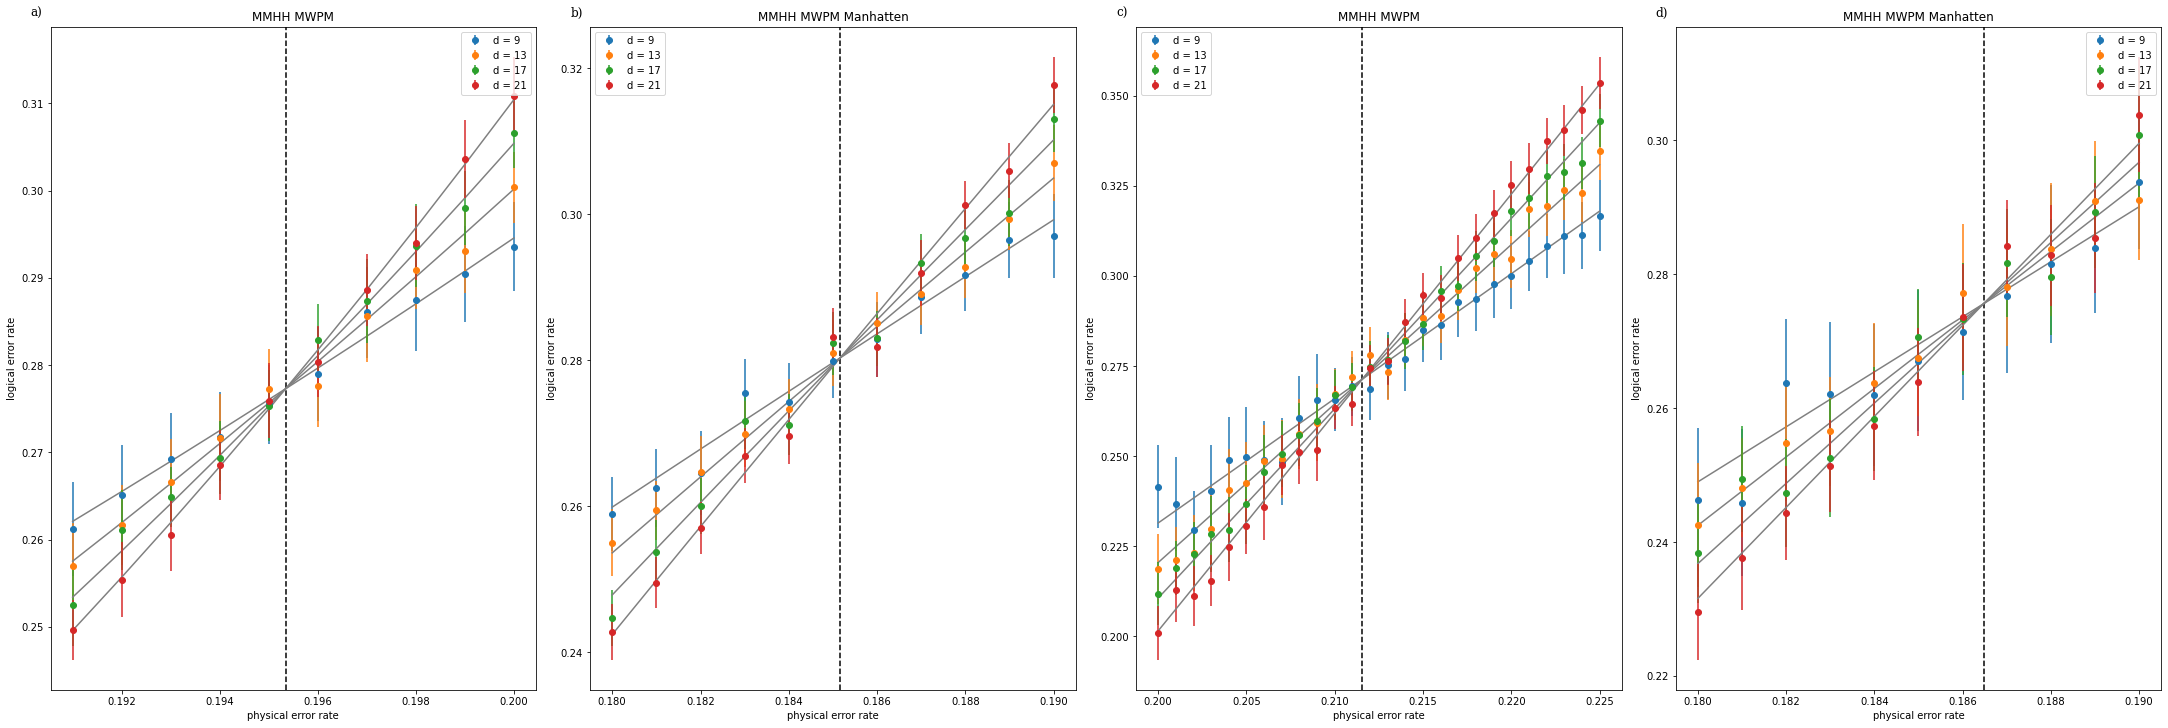

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [27]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)', 'd)']],
                              constrained_layout=True, figsize = (30,10))

thresholds_MMHH_MWPM[0.25] = calculate_threshold(data['MMHH']['MWPM'][0.25][0.5], 8, 22, 0.19, 0.215,
                    'MMHH MWPM', axs['a)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_manhatten[0.25] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.25][0.5], 8, 22, 0.175, 0.21,
                    'MMHH MWPM Manhatten', axs['b)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_MWPM[0.75] = calculate_threshold(data['MMHH']['MWPM'][0.75][0.5], 8, 22, 0.19, 0.24,
                    'MMHH MWPM', axs['c)'], calculate_threshold=True, non_uniform=True)
thresholds_MMHH_manhatten[0.75] = calculate_threshold(data['MMHH']['MWPM_manhatten'][0.75][0.5], 8, 22, 0.175, 0.21,
                    'MMHH MWPM Manhatten', axs['d)'], calculate_threshold=True, non_uniform=True)


for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')


plt.show()
fig.savefig('./non_uniform_thresholds.eps', format='eps', bbox_inches='tight')

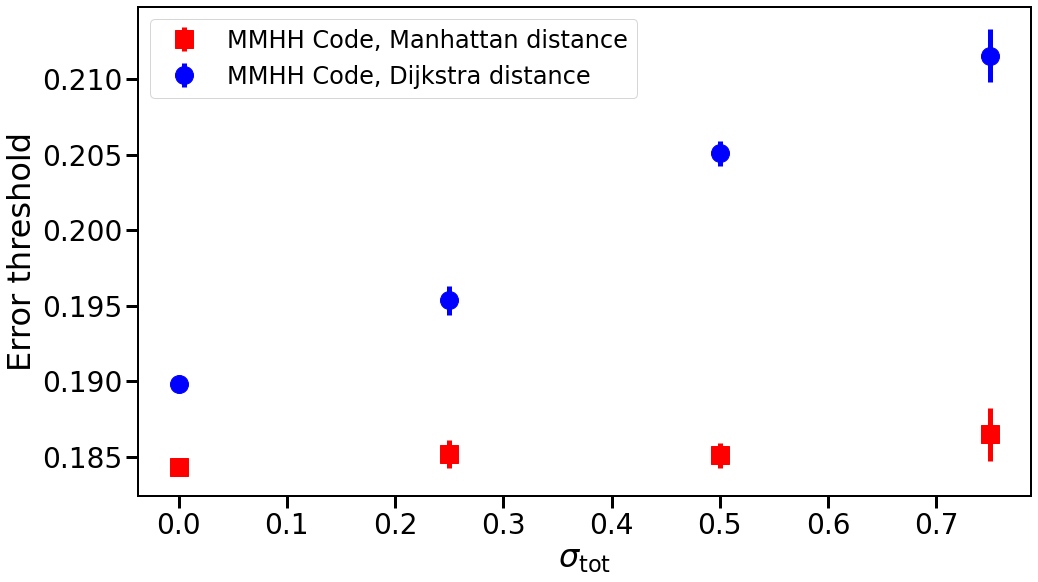

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [28]:
bias_arr= []

for bias in thresholds_MMHH_manhatten.keys():
    bias_arr.append(bias)

bias_arr.sort()
ler_man_arr = []
ler_eb_man_arr = []
ler_mwpm_arr = []
ler_eb_mwpm_arr = []


for bias in bias_arr:
    ler_man_arr.append(thresholds_MMHH_manhatten[bias][0])
    ler_mwpm_arr.append(thresholds_MMHH_MWPM[bias][0])
    ler_eb_man_arr.append(3*thresholds_MMHH_manhatten[bias][1])
    ler_eb_mwpm_arr.append(3*thresholds_MMHH_manhatten[bias][1])

fig, ax = plt.subplots(figsize=(16, 9))
ax.errorbar(bias_arr, ler_man_arr, yerr=ler_eb_man_arr, label='MMHH Code, Manhattan distance', marker='s', color='Red',
            linestyle='', markersize=18, elinewidth=5)
ax.errorbar(bias_arr, ler_mwpm_arr, yerr=ler_eb_mwpm_arr, label='MMHH Code, Dijkstra distance', marker='o',
            color='Blue',
            linestyle='', markersize=18, elinewidth=5)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.legend(loc='upper left', prop={'size': 24})
ax.set_ylabel('Error threshold', size=32)
ax.set_xlabel('$\sigma_{\mathrm{tot}}$', size=32)
ax.tick_params(axis='both', which='major', direction='out', length=12, width=3, colors='black', grid_color='black',
               grid_alpha=1)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.show()
fig.savefig('./12.eps', format='eps', bbox_inches='tight')